스타벅스 주가예측

In [ ]:
#40. 라이브러리 호출
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
#41. 데이터셋 가져오기
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SBUX.csv")
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [ ]:
#42. 날짜 칼럼을 인덱스로 사용
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True) #'date'칼럼을 인덱스로 사용

In [ ]:
#43. 데이터 형식 변경
data['Volume'] = data['Volume'].astype(float)

In [ ]:
print(data.dtypes)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [ ]:
#44. 훈련과 레이블 분리
X =data.iloc[:,:-1] #마지막 칼럼을 제외한 모든 칼럼을 x로 사용
y = data.iloc[:,5:6] #마지막 Volume을 레이블로사용
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2022-07-25   83.589996   83.699997   81.040001   81.500000   79.776222
2022-07-26   81.220001   81.419998   80.000000   80.309998   78.611397
2022-07-27   81.230003   83.410004   81.120003   82.959999   81.205345
2022-07-28   83.190002   84.889999   82.820000   84.669998   82.879166
2022-07-29   84.599998   84.980003   83.930000   84.779999   82.986847
...                ...         ...         ...         ...         ...
2023-07-17  100.830002  101.809998  100.040001  100.930000  100.930000
2023-07-18  100.739998  101.419998   99.860001  100.760002  100.760002
2023-07-19  100.620003  101.980003  100.620003  101.830002  101.830002
2023-07-20  101.779999  102.480003  100.699997  100.879997  100.879997
2023-07-21  101.800003  103.550003  101.610001  102.820000  102.820000

[250 rows x 5 columns]
                Volume
Date                  
2022-07

In [ ]:
#45. 데이터 분포 조정
ms = MinMaxScaler() #데이터의 모든 값이 0~1 사이에 존재하도록 분산 조정
ss = StandardScaler() #데이터가 평균 0, 분산 1이 되도록 분산 조정

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200,:] #훈련데이터셋
X_test = X_ss[200:,:] #테스트 데이터셋

y_train = y_ms[:200,:]
y_test = y_ms[200:,:]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (50, 5) (50, 1)


In [ ]:
#46. 데이터셋의 형태 및 크기조정
X_train_tensors = Variable(torch.Tensor(X_train)) #Variable로 감싸진 텐서는 .backward()가 호출될 때 자동으로 기울기가 계산
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],1,X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)


Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([50, 1, 5]) torch.Size([50, 1])


In [ ]:
#47. LSTM 네트워크
class LSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM, self).__init__()
    self.num_classes = num_classes #클래스 개수
    self.num_layers = num_layers #LSTM 계층의 개수
    self.hidden_size = hidden_size
    self.seq_length = seq_length #시퀀스 길이

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True ) #LSTM 계층
    self.fc_1 = nn.Linear(hidden_size, 128) #완전연결층
    self.fc = nn.Linear(128, num_classes) #출력층
    self.relu = nn.ReLU()

  def forward(self, x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #은닉 상태를 0으로 초기화
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #셀 상태를 0으로 초기화
    output, (hn, cn) = self.lstm(x,(h_0,c_0)) #LSTM계층에 은닉 상태와 셀 상태 적용
    hn = hn.view(-1, self.hidden_size)
    out = self.relu(hn)
    out = self.fc_1(out)
    out = self.relu(out)
    out = self.fc(out)
    return out


In [ ]:
#48 변수값 설정
num_epochs = 1000 #1000번의 에포크
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1

num_classes = 1
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1]) #앞에서 정의한 값들을 이용하여 LSTM 모델 학습
criterion =  torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
#49. 모델 학습
for epoch in range(num_epochs):
  outputs = model.forward(X_train_tensors_f) #전방향 학습
  optimizer.zero_grad()
  loss = criterion(outputs, y_train_tensors)
  loss.backward() #기울기계산

  optimizer.step() #오차 업데이트
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.01964
Epoch: 100, loss: 0.01933
Epoch: 200, loss: 0.01923
Epoch: 300, loss: 0.01914
Epoch: 400, loss: 0.01905
Epoch: 500, loss: 0.01897
Epoch: 600, loss: 0.01889
Epoch: 700, loss: 0.01881
Epoch: 800, loss: 0.01873
Epoch: 900, loss: 0.01866


In [ ]:
#50 모델 예측 결과를 출력하기 위한 데이터 크기 재구성
df_x_ss = ss.transform(data.iloc[:,:-1]) #데이터 정규화 (분포조정)
df_y_ms = ms.transform(data.iloc[:,-1:]) #데이터 정규화

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0],1,df_x_ss.shape[1]))


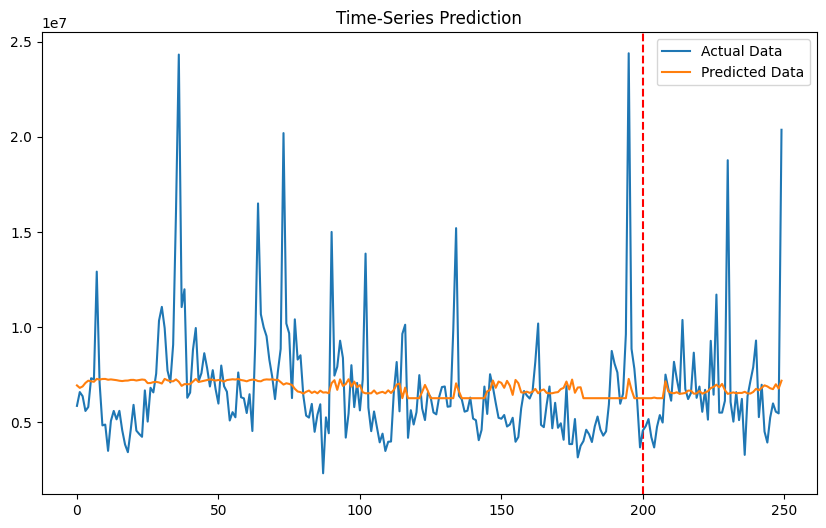

In [ ]:
#51 모델예측 결과 출력
train_predict = model(df_x_ss) #훈련 데이터셋을 모델에 적용하여 모델 학습
predicted = train_predict.data.numpy() #모델 학습 결괄르 넘파이로 변경
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted) #모델 학습을 위해 전처리했던것을 해제
label_y = ms.inverse_transform(label_y)
plt.figure(figsize = (10,6))
plt.axvline(x=200, c='r',linestyle='--')

plt.plot(label_y, label = 'Actual Data')
plt.plot(predicted, label = 'Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()